In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from apricot import FacilityLocationSelection

In [2]:
def greedy_maximin(data, remaining, selected,  n, metric="euclidean"):
    """
        data: pandas dataframe(rows=points, cols=dimensions)
            points to choose from
            
        remaining: indexes of `data` that are candidates for the next point
        
        selected: indexes of `data` that have already been included
        
        n: number of additional points to include
        
        metric: "euclidean" "cityblock"
            distance measures from scipy.spatial.distance
    """
    distances = []
    for _ in range(n):
        dists = distance.cdist(data.loc[selected], data.loc[remaining], metric)
        closest = dists.min(axis=0)  # distance between candidates and closest selection
        distances.append(closest.max())
        add = remaining[np.argmax(closest)]
        selected += [add]
        remaining.remove(add)

    return selected, distances

In [3]:
def within_set_distance(data, selected, metric="euclidean"):
    return distance.cdist(data.loc[selected],data.loc[selected], metric) 

In [4]:
task_map = pd.read_csv("https://raw.githubusercontent.com/Watts-Lab/task-mapping/master/task_map.csv", index_col="task")

In [5]:
# drop things that we can't play
task_map.drop('Railroad Route Construction game (Impossible Version)', inplace = True)

In [6]:
scores_dict = {}
for task in task_map.index:
    selected = [task]
    remaining = list(task_map.index.difference(selected))
    choices,scores = greedy_maximin(task_map, remaining, selected, n=10)
    scores_dict[task] = scores[9]

scores_dict

{'Categorization problem': 1.2666853861623764,
 'Mastermind': 1.1591455502371815,
 'Logic Problem': 1.138013480692106,
 'Sudoku': 1.1815937548338622,
 'Rank cities by population, rank words by familiarity': 1.245662832693769,
 'Shopping plan': 1.2783177766403093,
 'Carter Racing (Experimenterless Version)': 1.245662832693769,
 'Iterative lemonade stand task': 1.2492651678687603,
 'Reading the mind in the eyes': 1.245662832693769,
 'Writing story': 1.327927353825807,
 'Moral Reasoning (Disciplinary Action Case)': 1.327927353825807,
 'Word construction from a subset of letters': 1.327927353825807,
 'Carter Racing': 1.327927353825807,
 'Guessing the correlation': 1.245662832693769,
 'Wolf, goat and cabbage transfer': 1.327927353825807,
 'Room assignment task': 1.230500442813333,
 'Arithmetic problem 1': 1.2423124375329524,
 'Space Fortress': 1.1950364528599255,
 'Visual Oddball Target': 1.2852284292264256,
 'The N light bulbs game': 1.294694757035991,
 'Word completion given starting lett

In [7]:
print(np.quantile(list(scores_dict.values()), [0.5, 0.95]))

[1.25723242 1.32792735]


In [8]:
pd.Series(scores_dict).idxmax()

'Writing story'

In [9]:
selected = ['Writing story']
remaining = list(task_map.index.difference(selected))
choices,scores = greedy_maximin(task_map, remaining, selected, n=10)
choices

['Writing story',
 '9 Dot Problem',
 'Word construction from a subset of letters',
 'Image rating',
 'Checkers',
 'Run a mini business',
 'Typing game',
 'Whac-A-Mole',
 'Divergent Association Task',
 'Carter Racing',
 'Object based generalization for reasoning (Phyre)']

In [12]:
# print the scores
scores

[3.033024588462129,
 2.3611329688851113,
 2.023028412417927,
 1.7957277411343644,
 1.6941734671205697,
 1.651693174221916,
 1.4104539514341472,
 1.4049906884518972,
 1.3675509868542826,
 1.327927353825807]

In [13]:
def get_min_dist_within_set(selected):
    res = within_set_distance(task_map, selected)
    # the commented out code is the minimum of the pairwise distances
    #res[res == 0] = 10000000 # get rid of the diagonal, which is obviously zero
    return np.sum(res)/2
    #return np.min(res)

In [14]:
implemented = ['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association']
get_min_dist_within_set(implemented)

87.87285801782764

In [15]:
selected_abdullah = ['Search for Oil Task','Advertisement writing',"Wason's Selection Task",'To evacuate or not to evacuate','Space Fortress','Word completion given part of word','Graph coloring task','Estimating social quantity','Logic Problem','Divergent Association Task']
get_min_dist_within_set(selected_abdullah)

71.45196851015572

In [16]:
get_min_dist_within_set(choices)

105.16549147041633

In [17]:
# What happens if we started with room assignment as before?
selected = ['Room assignment task']
remaining = list(task_map.index.difference(selected))
print(greedy_maximin(task_map, remaining, selected, n=10)[0])
get_min_dist_within_set(greedy_maximin(task_map, remaining, selected, n=10)[0])

['Room assignment task', 'Summarize Discussion', 'Whac-A-Mole', '9 Dot Problem', 'Word construction from a subset of letters', 'Image rating', 'Putting food into categories', 'Typing game', 'Railroad Route Construction game', 'Run a mini business', 'Object based generalization for reasoning (Phyre)']


373.72511967237915

## Which tasks should we replace to improve our score?
What if we start with our existing set, and greedily replace tasks with the one most likely to improve our score?

In [18]:
original_tasks = ('Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Room assignment task', 'Divergent Association Task', 'Recall association')

In [19]:
# set the max number of replacements you're willing to make
MAX_NUM_TASKS_TO_REPLACE = 20
dists_per_iteration = []

# start with existing set
current_task_list = original_tasks

for i in range(MAX_NUM_TASKS_TO_REPLACE):
    # go through each one and try replacing it to find the most optimal replacement
    optimal_replacements = {}

    for task in current_task_list:
        selected_minus_task = list(current_task_list)
        selected_minus_task.remove(task)
        remaining = list(task_map.index.difference(selected_minus_task))
        new_set = greedy_maximin(task_map, remaining, selected_minus_task, n=1)[0] # get a replacement'
        optimal_replacements[task] = get_min_dist_within_set(new_set)
    
    optimal_task_to_replace = pd.Series(optimal_replacements).idxmax()
    print(optimal_task_to_replace)
    
    # now set the task to the optimally-replaced one
    selected_minus_task = list(current_task_list)
    selected_minus_task.remove(optimal_task_to_replace)
    remaining = list(task_map.index.difference(selected_minus_task))
    current_task_list = (greedy_maximin(task_map, remaining, selected_minus_task, n=1)[0]) # get a replacement'
    print(current_task_list)
    print(get_min_dist_within_set(list(current_task_list)))
    dists_per_iteration.append(get_min_dist_within_set(list(current_task_list)))

Room assignment task
['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Divergent Association Task', 'Recall association', 'Checkers']
108.0039640435684
Recall association
['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Divergent Association Task', 'Checkers', 'Word completion given starting letter']
109.82034636741712
Divergent Association Task
['Euclidean traveling salesperson', 'Allocating resources to programs', '9 Dot Problem', 'Guessing the correlation', 'Abstract grid task', 'Advertisement writing', 'Whac-A-Mole', 'Putting food into categories', 'Checkers', 'Word completion given starting letter', 'To evacuate or not to evacuate']
110.70384339869409
Word compl

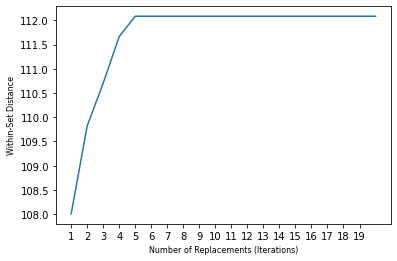

In [20]:
plt.plot(range(1,len(dists_per_iteration)+1),dists_per_iteration)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel('Number of Replacements (Iterations)', fontsize=8)
plt.ylabel('Within-Set Distance', fontsize=8)
plt.show()

### Visualize how well the algorithm performs against the out-of-the-box one from apricot

100%|██████████| 10.0/10.0 [00:00<00:00, 3.07kit/s]


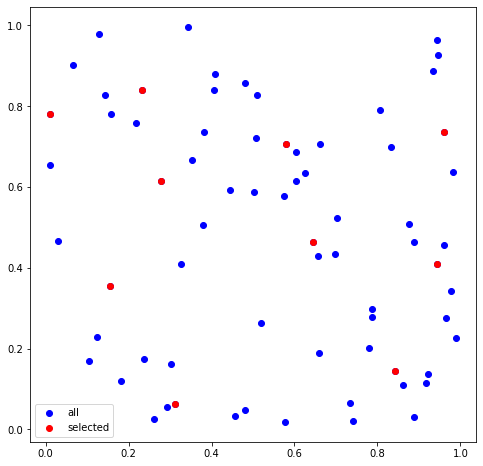

In [56]:
X_random = np.random.uniform(0, 1, (70,2))

# for documentation: https://apricot-select.readthedocs.io/en/latest/functions/facilityLocation.html
selector = FacilityLocationSelection(10, metric='euclidean',
                                     optimizer='naive',
                                     n_jobs=10,
                                     verbose=True,
                                    ).fit(X_random)
X_subset = selector.transform(X_random)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.scatter(X_random[:, 0], X_random[:, 1], label='all', color='blue')
ax.scatter(X_subset[:, 0], X_subset[:, 1], label='selected', color='red')
ax.legend()

In [53]:
X_random_df = pd.DataFrame(X_random)

scores_dict_rand = {}
for item in X_random_df.index:
    selected = [item]
    remaining = list(X_random_df.index.difference(selected))
    choices,scores = greedy_maximin(X_random_df, remaining, selected, n=10)
    scores_dict_rand[item] = scores[9]

score_rand_max = pd.Series(scores_dict_rand).idxmax()

selected = [score_rand_max]
remaining = list(X_random_df.index.difference(selected))
choices,scores = greedy_maximin(X_random_df, remaining, selected, n=10)
choices

[46, 22, 12, 4, 55, 32, 15, 59, 42, 61, 2]

In [54]:
X_subset_james = np.asarray(X_random_df.iloc[choices])

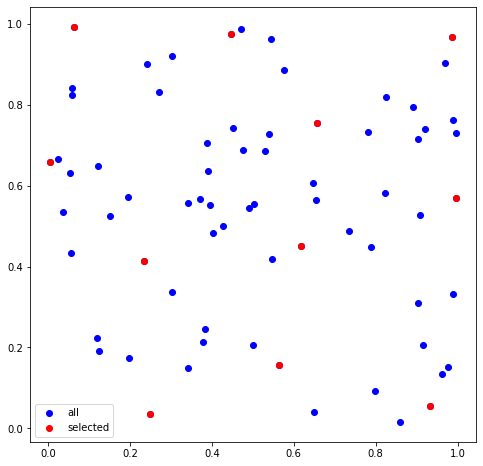

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.scatter(X_random[:, 0], X_random[:, 1], label='all', color='blue')
ax.scatter(X_subset_james[:, 0], X_subset_james[:, 1], label='selected', color='red')
ax.legend()